# ⚛️ H₃⁺ VQE — Noise Scans, ΔE Shifts & Fidelity

This notebook studies how **noise** affects **VQE** for the trihydrogen
cation **H₃⁺**, using a combination of:

- A **lightweight noisy VQE demo** (educational)  
- A full **UCCSD-based noise study** with:
  - Depolarizing noise  
  - Amplitude damping  
  - Multi-seed statistics  
  - Optimizer comparison  
  - Ansatz comparison  

---

## 🧩 Part 1 — Manual Noisy VQE Demo (Educational)

- Small TwoQubit-RY-CNOT ansatz  
- Explicit insertion of:
  - `DepolarizingChannel(p)`  
  - `AmplitudeDamping(p)`  
- Quick GradientDescent optimisation  

This is just to illustrate *how noise is injected at the circuit level*.

---

## 🟦 Part 2 — UCCSD Noise Study (Production-Style)

Using a **UCCSD ansatz** via `excitation_ansatz`, we:

1. Build a **noiseless reference** (multi-seed)  
2. Sweep noise strengths and compute:
   - **Energy error ΔE = E_noisy − E_ref**  
   - **Fidelity to the reference state**  
3. Compare **optimizers** under noise  
4. Compare **ansatz choices** under noise  

All runs are:

- **Cache-aware**  
- **Reproducible**  
- Saved as JSON + PNG into your shared `images/` and `runs/` structure.


In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt

import sys, os, json
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from vqe.vqe_utils import (
    excitation_ansatz,
    set_seed,
    get_optimizer,
    ensure_dirs,
    make_run_config_dict,
    run_signature,
    find_existing_run,
    save_run_record,
    build_run_filename,
    init_params,
    IMG_DIR,
    ANSATZES,
)

ensure_dirs()

# 🔧 Global Configuration — H₃⁺ System

Geometry: equilateral H₃⁺ (Å)  
Basis: STO-3G  
Charge: +1  
Electrons: 2  

We also define:

- seed set for averaging  
- noise levels to scan  
- default optimizer configuration  

In [2]:
# Seeds for statistics
seeds = np.arange(0, 3)

# Geometry (equilateral triangle approximation)
symbols = ["H", "H", "H"]
coordinates = np.array([
    [0.000000,  1.000000,  0.000000],
    [-0.866025, -0.500000, 0.000000],
    [ 0.866025, -0.500000, 0.000000],
])

basis = "STO-3G"
electrons = 2
optimizer_name = "Adam"
stepsize = 0.2
max_iterations = 50
ansatz_desc = "TwoQubit-RY-CNOT"  # used as a label in config; default ansatz is UCCSD

hamiltonian, qubits = qchem.molecular_hamiltonian(
    symbols, coordinates, charge=+1, basis=basis
)
hf = qchem.hf_state(electrons, qubits)

num_wires = qubits
singles, doubles = qchem.excitations(electrons, qubits)

noise_levels = np.arange(0, 0.11, 0.025)

print(f"H₃⁺ → {num_wires} qubits, {len(singles)} singles, {len(doubles)} doubles")

H₃⁺ → 6 qubits, 4 singles, 4 doubles


# 🧩 Part 1 — Manual Noisy VQE Demo (TwoQubit-RY-CNOT)

This is a **small illustrative VQE** with:

- A simple two-qubit ansatz  
- Explicit depolarizing + amplitude-damping noise  
- A short optimisation loop  

It is **not** the main scientific result — the full study below uses UCCSD.

[demo] Step 01/30: E = 1.465610 Ha
[demo] Step 02/30: E = 1.458775 Ha
[demo] Step 03/30: E = 1.450147 Ha
[demo] Step 04/30: E = 1.439271 Ha
[demo] Step 05/30: E = 1.425586 Ha
[demo] Step 06/30: E = 1.408404 Ha
[demo] Step 07/30: E = 1.386895 Ha
[demo] Step 08/30: E = 1.360064 Ha
[demo] Step 09/30: E = 1.326749 Ha
[demo] Step 10/30: E = 1.285617 Ha
[demo] Step 11/30: E = 1.235190 Ha
[demo] Step 12/30: E = 1.173906 Ha
[demo] Step 13/30: E = 1.100216 Ha
[demo] Step 14/30: E = 1.012747 Ha
[demo] Step 15/30: E = 0.910514 Ha
[demo] Step 16/30: E = 0.793189 Ha
[demo] Step 17/30: E = 0.661369 Ha
[demo] Step 18/30: E = 0.516803 Ha
[demo] Step 19/30: E = 0.362478 Ha
[demo] Step 20/30: E = 0.202499 Ha
[demo] Step 21/30: E = 0.041730 Ha
[demo] Step 22/30: E = -0.114754 Ha
[demo] Step 23/30: E = -0.262295 Ha
[demo] Step 24/30: E = -0.397192 Ha
[demo] Step 25/30: E = -0.517029 Ha
[demo] Step 26/30: E = -0.620740 Ha
[demo] Step 27/30: E = -0.708445 Ha
[demo] Step 28/30: E = -0.781153 Ha
[demo] Step 2

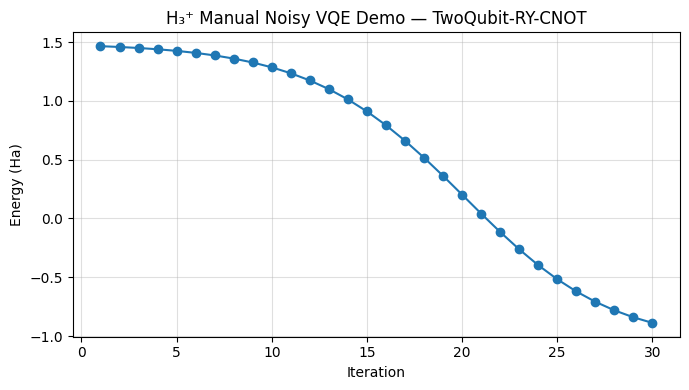

In [3]:
def two_qubit_ry_cnot(params, wires):
    """Tiny 2-qubit ansatz: RY → CNOT → RY."""
    qml.RY(params[0], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[1], wires=wires[1])

# Demo noise parameters
p_dep_demo = 0.05
p_amp_demo = 0.05

dev_demo = qml.device("default.mixed", wires=num_wires)

@qml.qnode(dev_demo, diff_method="finite-diff")
def noisy_demo_energy(params):
    # Apply ansatz on first two qubits (toy example)
    two_qubit_ry_cnot(params, wires=[0, 1])

    # Apply channels on all qubits
    for w in range(num_wires):
        qml.DepolarizingChannel(p_dep_demo, wires=w)
        qml.AmplitudeDamping(p_amp_demo, wires=w)

    return qml.expval(hamiltonian)

# Tiny optimisation loop (educational only)
set_seed(0)
opt_demo = qml.GradientDescentOptimizer(stepsize=0.1)
params_demo = 0.1 * np.random.randn(2, requires_grad=True)

energies_demo = []
n_steps_demo = 30

for step in range(n_steps_demo):
    params_demo, e_prev = opt_demo.step_and_cost(noisy_demo_energy, params_demo)
    e_val = float(noisy_demo_energy(params_demo))
    energies_demo.append(e_val)
    print(f"[demo] Step {step+1:02d}/{n_steps_demo}: E = {e_val:.6f} Ha")

plt.figure(figsize=(7, 4))
plt.plot(range(1, n_steps_demo + 1), energies_demo, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₃⁺ Manual Noisy VQE Demo — TwoQubit-RY-CNOT")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.savefig(os.path.join(IMG_DIR, "H3plus_Manual_Noisy_VQE_Demo.png"), dpi=300)
plt.show()

# 🟦 Part 2 — UCCSD QNode Factory (Noisy / Noiseless)

For the **real noise study**, we now use a **UCCSD ansatz** (by default) via
`excitation_ansatz`.

This helper returns a cost/state QNode with:

- `default.qubit` (noiseless) or `default.mixed` (noisy)  
- Depolarizing + amplitude-damping channels when `noisy=True`  
- Either:
  - UCCSD (`excitation_ansatz`)  
  - or any ansatz from `ANSATZES`  

In [4]:
def get_vqe_qnode(
    ansatz_fn=None,
    noisy=True,
    return_state=False,
    depolarizing_prob=0.0,
    amplitude_damping_prob=0.0,
):
    """Factory for noisy/noiseless VQE QNodes."""
    dev = qml.device(
        "default.mixed" if noisy else "default.qubit",
        wires=num_wires,
    )
    diff_method = "finite-diff" if noisy else "parameter-shift"

    @qml.qnode(dev, diff_method=diff_method)
    def circuit(params):

        # Default: UCCSD via excitation_ansatz
        if ansatz_fn == excitation_ansatz:
            excitation_ansatz(
                params,
                wires=range(num_wires),
                hf_state=hf,
                excitations=(singles, doubles),
                excitation_type="both",
            )
        else:
            ansatz_fn(params, wires=range(num_wires))

        if noisy:
            for w in range(num_wires):
                qml.DepolarizingChannel(depolarizing_prob, wires=w)
                qml.AmplitudeDamping(amplitude_damping_prob, wires=w)

        return qml.state() if return_state else qml.expval(hamiltonian)

    return circuit

# 🧮 Part 3 — Cache-Aware UCCSD VQE Runner

`run_vqe_with_cache`:

- Selects an ansatz:
  - default → UCCSD (`excitation_ansatz`)  
  - or any named ansatz from `ANSATZES`  
- Builds a config dictionary  
- Computes a signature and checks disk for an existing run  
- If absent:
  - runs VQE with the chosen noise model  
  - stores energies, final params, and (optionally) final state  

In [5]:
def run_vqe_with_cache(
    seed,
    noisy=True,
    dep_prob=0.0,
    amp_prob=0.0,
    optimizer_name="Adam",
    ansatz_name=None,
):
    """Run (or load) a noisy/noiseless VQE for H₃⁺."""
    ansatz_fn = ANSATZES.get(ansatz_name, excitation_ansatz)
    set_seed(seed)

    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc=ansatz_name or ansatz_desc,
        optimizer_name=optimizer_name,
        stepsize=stepsize,
        max_iterations=max_iterations,
        seed=seed,
        noisy=noisy,
        depolarizing_prob=dep_prob,
        amplitude_damping_prob=amp_prob,
    )

    sig = run_signature(cfg)
    fname = build_run_filename("H3plus_Noise_Error", optimizer_name, seed, sig)
    existing = find_existing_run(sig)

    # --- Load existing ---
    if existing:
        with open(existing) as f:
            rec = json.load(f)
        energies = rec["energies"]
        params = np.array(rec["final_params"])
        final_state = (
            np.array(rec.get("final_state_real", []))
            + 1j * np.array(rec.get("final_state_imag", []))
        )
        return energies, params, final_state

    # --- Compute fresh ---
    if ansatz_name is None or ansatz_name not in ANSATZES:
        # Default: UCCSD (singles + doubles)
        n_params = len(singles) + len(doubles)
        params = 0.01 * np.random.randn(n_params)
    else:
        params = init_params(ansatz_name, num_wires=num_wires, scale=0.01)

    cost_fn = get_vqe_qnode(
        ansatz_fn=ansatz_fn,
        noisy=noisy,
        return_state=False,
        depolarizing_prob=dep_prob,
        amplitude_damping_prob=amp_prob,
    )
    opt = get_optimizer(optimizer_name, stepsize=stepsize)

    energies = [cost_fn(params)]
    for _ in range(max_iterations):
        params, e_prev = opt.step_and_cost(cost_fn, params)
        energies.append(e_prev)

    # Final state (for fidelity)
    final_state = get_vqe_qnode(
        ansatz_fn=ansatz_fn,
        noisy=noisy,
        return_state=True,
        depolarizing_prob=dep_prob,
        amplitude_damping_prob=amp_prob,
    )(params)

    rec = {
        "config": cfg,
        "energies": np.asarray(energies).tolist(),
        "final_params": np.asarray(params).tolist(),
        "final_state_real": np.real(final_state).tolist(),
        "final_state_imag": np.imag(final_state).tolist(),
    }
    save_run_record(fname, rec)

    return energies, params, final_state

# 🧮 Part 4 — Fidelity Helper & Noise Statistics

We define:

- `fidelity(pure_ket, state_or_rho)`  
- `compute_noise_stats(...)`  

which compute:

- Mean / std of **energy error** ΔE  
- Mean / std of **fidelity** vs a reference state  

across seeds and noise levels.

In [6]:
def fidelity(pure_ket, state_or_rho):
    """Fidelity between pure reference and statevector or density matrix."""
    if state_or_rho.ndim == 1:
        return np.abs(np.vdot(pure_ket, state_or_rho)) ** 2
    return np.real(np.vdot(pure_ket, state_or_rho @ pure_ket))


def compute_noise_stats(
    noise_values,
    ansatz_name=None,
    dep_prob=0.0,
    amp_prob=0.0,
    optimizer_name="Adam",
):
    """Compute ΔE and fidelity statistics over seeds for a set of noise values."""
    energy_means, energy_stds = [], []
    fidelity_means, fidelity_stds = [], []

    for p in noise_values:
        results = [
            run_vqe_with_cache(
                seed=s,
                ansatz_name=ansatz_name,
                noisy=True,
                dep_prob=(p if dep_prob > 0 else 0.0),
                amp_prob=(p if amp_prob > 0 else 0.0),
                optimizer_name=optimizer_name,
            )
            for s in seeds
        ]

        noisy_energies = [r[0][-1] for r in results]
        dE = np.array(noisy_energies) - reference_energy

        energy_means.append(np.mean(dE))
        energy_stds.append(np.std(dE))

        fid = [fidelity(pure_state, r[2]) for r in results]
        fidelity_means.append(np.mean(fid))
        fidelity_stds.append(np.std(fid))

    return energy_means, energy_stds, fidelity_means, fidelity_stds

# 🟢 Part 5 — Noiseless Multi-Seed Reference (UCCSD)

Before scanning noise, we build a **reference**:

- UCCSD ansatz (`excitation_ansatz`)  
- Noiseless device  
- Multiple seeds  

We store:

- `reference_energy` = mean final energy  
- `pure_state` = reference statevector from the first seed  

In [7]:
noiseless_results = [
    run_vqe_with_cache(s, noisy=False, optimizer_name=optimizer_name)
    for s in seeds
]

noiseless_energies = [r[0][-1] for r in noiseless_results]
noiseless_states = [r[2] for r in noiseless_results]

reference_energy = np.mean(noiseless_energies)
pure_state = noiseless_states[0]

print("Reference energy (mean over seeds):", reference_energy)

Reference energy (mean over seeds): -1.269936084039088


# 📉 Part 6 — Convergence Curves Under Noise (Depolarizing)

We now plot convergence curves for **depolarizing noise**, averaging over seeds for
each noise probability.

The shaded region indicates the **standard deviation** over seeds.

KeyboardInterrupt: 

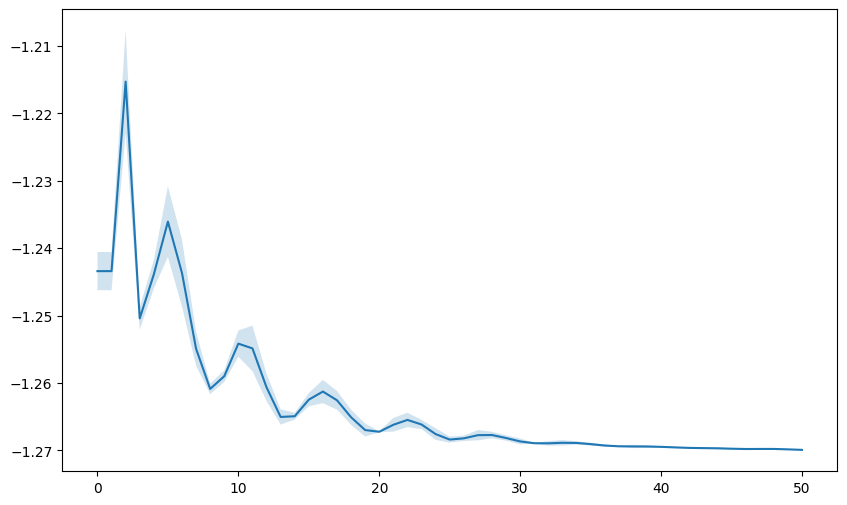

In [8]:
plt.figure(figsize=(10, 6))
noise_type = "Depolarizing"

for p in noise_levels:
    all_energies = []
    for s in seeds:
        E, _, _ = run_vqe_with_cache(
            seed=s,
            noisy=True,
            dep_prob=(p if noise_type == "Depolarizing" else 0.0),
            amp_prob=(p if noise_type == "Amplitude" else 0.0),
            optimizer_name=optimizer_name,
        )
        all_energies.append(E)

    min_len = min(len(e) for e in all_energies)
    arr = np.array([e[:min_len] for e in all_energies])

    mean_energy = arr.mean(axis=0)
    std_energy = arr.std(axis=0)

    plt.fill_between(
        range(min_len),
        mean_energy - std_energy,
        mean_energy + std_energy,
        alpha=0.2,
    )
    plt.plot(range(min_len), mean_energy, label=f"{noise_type} p={p:.3f}")

plt.axhline(reference_energy, color="k", linestyle="--", label="Reference")
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title(f"H₃⁺ VQE Convergence: {noise_type} Noise")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H3plus_{noise_type}_Convergence.png", dpi=300)
plt.show()

# 📊 Part 7 — ΔE & Fidelity vs Noise (Depolarizing vs Amplitude Damping)

We now compare:

- **Energy error** ΔE  
- **Fidelity** vs reference  

for:

- Depolarizing noise  
- Amplitude damping  

In [ ]:
energy_errors_dep, energy_stds_dep, fidelity_dep, fidelitystd_dep = compute_noise_stats(
    noise_levels, dep_prob=1, amp_prob=0
)

energy_errors_amp, energy_stds_amp, fidelity_amp, fidelitystd_amp = compute_noise_stats(
    noise_levels, dep_prob=0, amp_prob=1
)

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.errorbar(
    noise_levels, energy_errors_dep, yerr=energy_stds_dep,
    fmt="o-", label="Depolarizing"
)
plt.errorbar(
    noise_levels, energy_errors_amp, yerr=energy_stds_amp,
    fmt="s-", label="Amplitude"
)
plt.ylabel("Energy Error ΔE (Ha)")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.errorbar(
    noise_levels, fidelity_dep, yerr=fidelitystd_dep,
    fmt="o-", label="Depolarizing"
)
plt.errorbar(
    noise_levels, fidelity_amp, yerr=fidelitystd_amp,
    fmt="s-", label="Amplitude"
)
plt.xlabel("Noise Probability")
plt.ylabel("Fidelity")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H3plus_Noise_Error.png", dpi=300)
plt.show()

# ⚙️ Part 8 — Optimizer Comparison (Depolarizing Noise)

We now compare:

- `GradientDescent`  
- `Adam`  
- `Momentum`  

by looking at **fidelity vs noise**, averaged over seeds.

In [ ]:
optimizers = ["GradientDescent", "Adam", "Momentum"]

plt.figure(figsize=(10, 7))
for opt_name in optimizers:
    _, _, fid_mean, fid_std = compute_noise_stats(
        noise_levels, dep_prob=1, amp_prob=0, optimizer_name=opt_name
    )
    plt.errorbar(noise_levels, fid_mean, yerr=fid_std, fmt="o-", label=opt_name)

plt.xlabel("Noise Probability")
plt.ylabel("Fidelity")
plt.title("H₃⁺ Fidelity vs Noise — Optimizer Comparison")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H3plus_Noise_Optimizers.png", dpi=300)
plt.show()

# 🧱 Part 9 — Ansatz Comparison (Depolarizing Noise)

Finally, we compare all ansatzes in `ANSATZES`:

For each ansatz:

1. Build a **noiseless reference** (multi-seed)  
2. Compute fidelity vs noise under depolarizing noise  

This highlights how circuit structure interacts with noise.

In [ ]:
plt.figure(figsize=(10, 6))

for ansatz_name in ANSATZES:
    # Rebuild reference for this ansatz
    noiseless_results = [
        run_vqe_with_cache(
            s, noisy=False,
            optimizer_name=optimizer_name,
            ansatz_name=ansatz_name,
        )
        for s in seeds
    ]

    energies0 = [r[0][-1] for r in noiseless_results]
    states0 = [r[2] for r in noiseless_results]

    reference_energy = np.mean(energies0)
    pure_state = states0[0]

    # Noise statistics for this ansatz
    _, _, fid_mean, fid_std = compute_noise_stats(
        noise_levels,
        ansatz_name=ansatz_name,
        dep_prob=1,
        amp_prob=0,
        optimizer_name=optimizer_name,
    )

    plt.errorbar(noise_levels, fid_mean, yerr=fid_std, fmt="o-", label=ansatz_name)

plt.xlabel("Noise Probability")
plt.ylabel("Fidelity")
plt.title("H₃⁺ Fidelity vs Noise — Ansatz Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H3plus_Noise_Ansatzes.png", dpi=300)
plt.show()

# 🧾 Summary

In this notebook you:

- Built a **manual noisy VQE demo** (TwoQubit-RY-CNOT) to see noise at the circuit level  
- Constructed a **UCCSD noiseless reference** for H₃⁺  
- Performed **noise sweeps** with depolarizing and amplitude damping  
- Quantified:
  - Energy error ΔE vs noise  
  - Fidelity vs noise  
- Compared **optimizers** under noise  
- Compared **ansatz choices** under depolarizing noise  

This completes a full **H₃⁺ VQE noise analysis**, aligned with the style and structure
of your H₂ noise notebooks, while using **UCCSD** for the main scientific results.